# ENCODER DECODER MODEL FOR WORD LEVEL EMBEDDING

In [ ]:
## LOADING THE REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import tensorflow as tf
from  tensorflow.keras.preprocessing.sequence import pad_sequences
from  sklearn.model_selection import train_test_split
from tqdm import tqdm

## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## LOADING THE PROCESSED DATASET  

df= pd.read_csv("/content/drive/MyDrive/ColabNotebooks/cs2/processed_data.csv")
df.columns = ["enc_input","dec_input","y"] 
df["dec_output"] = df.dec_input
df

,enc_input,dec_input,y,dec_output
0,and he took in my favorite subject like soccer,and he took in my favorite subjects like soccer,1,and he took in my favorite subjects like soccer
1,actually who let me know about lang 8 was him,actually he was the one who let me know about ...,1,actually he was the one who let me know about ...
2,his kanji is ability is much better than me,his kanji ability is much better than mine,1,his kanji ability is much better than mine
3,we have known each other for only half a year ...,we have known each other for only half a year ...,1,we have known each other for only half a year ...
4,i heard a sentence last night when i watched tv,i heard a sentence last night when i was watch...,1,i heard a sentence last night when i was watch...
...,...,...,...,...
505893,hmmm thk i usually book on wkends depends la,hmm i think i usually book on weekends it depends,2,hmm i think i usually book on weekends it depends
505894,ask them got any sms messages to gif me leinow...,can you ask them whether they have for any sms...,2,can you ask them whether they have for any sms...
505895,we r near coca oredi,we are near coca already,2,we are near coca already
505896,hall eleven got lectures le mahn forget abt co...,hall eleven got lectures and forget about comp...,2,hall eleven got lectures and forget about comp...


## Adding start and end token

In [ ]:
## THE INPUTS TO THE DECODER REQUIRES SPECIAL TOKENS FOR THE START AND THE END SO WE ARE GOING TO USE 
## <start> AS BEGINING TOKEN
## <end>  AS END TOKEN

df["dec_input"]= "<start> " + df["dec_input"]
df["dec_output"] =  df["dec_output"] + " <end>" 
df

,enc_input,dec_input,y,dec_output
0,and he took in my favorite subject like soccer,<start> and he took in my favorite subjects li...,1,and he took in my favorite subjects like socce...
1,actually who let me know about lang 8 was him,<start> actually he was the one who let me kno...,1,actually he was the one who let me know about ...
2,his kanji is ability is much better than me,<start> his kanji ability is much better than ...,1,his kanji ability is much better than mine <end>
3,we have known each other for only half a year ...,<start> we have known each other for only half...,1,we have known each other for only half a year ...
4,i heard a sentence last night when i watched tv,<start> i heard a sentence last night when i w...,1,i heard a sentence last night when i was watch...
...,...,...,...,...
505893,hmmm thk i usually book on wkends depends la,<start> hmm i think i usually book on weekends...,2,hmm i think i usually book on weekends it depe...
505894,ask them got any sms messages to gif me leinow...,<start> can you ask them whether they have for...,2,can you ask them whether they have for any sms...
505895,we r near coca oredi,<start> we are near coca already,2,we are near coca already <end>
505896,hall eleven got lectures le mahn forget abt co...,<start> hall eleven got lectures and forget ab...,2,hall eleven got lectures and forget about comp...


## Splitting And Sampling around 100k datapoints

---
##### THE TOTAL DATASET HAS 500K DATAPOINTS WHICH WILL TAKE MUCH HIGHER TRAINING TIME. THEREFORE I AM SAMPLING ONE-FIFTH OF THE TOTAL DATASET



In [ ]:
df_sampled = pd.concat((df[df.y==1].sample(frac= 0.2,random_state=1),df[df.y==2]))

In [ ]:
## ONCE THE DATA IS SAMPLED WE ARE SPLITTIND THE DATA IN TO TRAIN AND TEST

df_train ,df_val = train_test_split(df_sampled,test_size=0.2,random_state = 3, stratify = df_sampled.y )

In [ ]:
## IN THE COLUMN WHICH HAS DECODER INPUTS ADDING "<end>" TOKEN TO BE LEARNED BY THE TOKENIZER

df_train["dec_input"].iloc[0]  = df_train.iloc[0]["dec_input"] + " <end>"
df_train

,enc_input,dec_input,y,dec_output
104937,my older brother work in company,<start> my older brother works for a company <...,1,my older brother works for a company <end>
135435,the price of tokyo sky tree is observation deck,<start> the price of admission to the tokyo sk...,1,the price of admission to the tokyo sky tree i...
501359,i am afraid of taking a job now a days,<start> i am afraid of getting job a now days,1,i am afraid of getting job a now days <end>
407321,it is too way short but that is all for this m...,<start> it is way too short but that is all fo...,1,it is way too short but that is all for this m...
296037,i really like these sports because the uniform...,<start> i really like these sports because the...,1,i really like these sports because their unifo...
...,...,...,...,...
492361,i decided to go to america in this august,<start> i decided to go to america this august,1,i decided to go to america this august <end>
86561,my daughter was quite nervous to start with bu...,<start> my daughter was quite nervous at the s...,1,my daughter was quite nervous at the start but...
48899,omg it is crawling out i thought to myself,<start> omg it is crawling out i thought to ...,1,omg it is crawling out i thought to myself <...
218985,skip beat with spanish subtitle,<start> skip beat with spanish subtitles,1,skip beat with spanish subtitles <end>


In [ ]:
## VALIDATION DATA
df_val

,enc_input,dec_input,y,dec_output
71342,in the last stage add the mixture of potato an...,<start> in the last stage add the mixture of p...,1,in the last stage add the mixture of potato an...
395034,of course the experiences of japanese are also...,<start> of course the experiences of the japan...,1,of course the experiences of the japanese are ...
208880,but watching other is play gives me many stimu...,<start> but watching others play is exciting a...,1,but watching others play is exciting after all...
198826,and this is my new tattoos,<start> and these are my new tattoos,1,and these are my new tattoos <end>
313016,i write a diary in english for the first time,<start> i am writing a diary in english for th...,1,i am writing a diary in english for the first ...
...,...,...,...,...
247300,i love family,<start> i love my family,1,i love my family <end>
505055,ok i going soon and also send xyan home at the...,<start> ok i am going soon and also send xyan ...,2,ok i am going soon and also send xyan home at ...
126924,house car people had been washed away by the b...,<start> houses cars and people had been washed...,1,houses cars and people had been washed away by...
53162,on the weekend i had to go back to my home to ...,<start> on the weekend i had to go back to my ...,1,on the weekend i had to go back to my home to ...


In [ ]:
## HERE I AM SAMPLING 1000 POINTS FROM THE DATAFRAME AS TEST DATA WHICH ARE NOT PRESEENT IN THE TRAIN AND VALIDAION DATA
np.random.seed(5) 
df_test = df.loc[np.random.choice(np.array([x for x in df.index.values if x not in df_sampled.index.values]),1000,replace= False,)]
df_test

,enc_input,dec_input,y,dec_output
144583,you are meeting your friends and going to a ba...,<start> you are meeting your friends and going...,1,you are meeting your friends and going to a ba...
455599,but since i got here i have not studied a lot,<start> but since i got here i have not studie...,1,but since i got here i have not studied very ...
13922,we had lunch with them in a house flooded by t...,<start> we had lunch with those whose house ha...,1,we had lunch with those whose house had been f...
128968,an professor introduced me to her,<start> a professor introduced me to her,1,a professor introduced me to her <end>
402800,his companions were having drinks in front of ...,<start> his companions were having drinks in f...,1,his companions were having drinks in front of ...
...,...,...,...,...
352632,so many people is suffuring from hunger povert...,<start> so many people are suffering from hung...,1,so many people are suffering from hunger and p...
191449,i wish i could be of some help during this big...,<start> i hope to offer some help in this big ...,1,i hope to offer some help in this big change b...
179722,anyway what i hope is he will come to shanghai...,<start> anyway what i hope is that he will com...,1,anyway what i hope is that he will come to sha...
38604,i just saw something on the facebook,<start> i just saw something on facebook,1,i just saw something on facebook <end>


## Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
## TOKENIZER FOR ENCODER INPUT
tk_inp = Tokenizer()
tk_inp.fit_on_texts(df_train.enc_input.apply(str))

In [ ]:
# TOKENIZER FOR DECODER INPUT
tk_out = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' )
tk_out.fit_on_texts(df_train.dec_input.apply(str))

## DATA PIPELINE

In [ ]:
## THIS CLASS CONVERTS TEXT DATA TO INTEGER SEQUENCES AND RETURNS THE PADDED SEQUENCES

class Dataset :
    def __init__(self, data , tk_inp ,tk_out, max_len):
        ## SETTING THE REQUIRED ATTRIBUTES
        self.encoder_inp = data["enc_input"].apply(str).values
        self.decoder_inp = data["dec_input"].apply(str).values
        self.decoder_out = data["dec_output"].apply(str).values
        self.tk_inp = tk_inp
        self.tk_out = tk_out
        self.max_len = max_len
        
    def __getitem__(self,i):
        # INPUT SEQUENCES
        self.encoder_seq = self.tk_inp.texts_to_sequences([self.encoder_inp[i]])
        # DECODER INPUT SEQUENCES 
        self.decoder_inp_seq = self.tk_out.texts_to_sequences([self.decoder_inp[i]])
        # DECODER INPUT SEQUENCES
        self.decoder_out_seq = self.tk_out.texts_to_sequences([self.decoder_out[i]])
        
        # PADDING THE ENCODER INPUT SEQUENCES
        self.encoder_seq = pad_sequences(self.encoder_seq, padding="post",maxlen = self.max_len)
        # PADDING THE DECODER INPUT SEQUENCES
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, padding="post",maxlen = self.max_len)
        # PADDING DECODER OUTPUT SEQUENCES
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq ,padding="post", maxlen = self.max_len)

        ##  RETURNING THE ENCODER INPUT , DECODER INPUT , AND DECODER OUTPUT
        return self.encoder_seq ,  self.decoder_inp_seq,  self.decoder_out_seq
    
    def __len__(self):
        # RETURN THE LEN OF INPUT ENDODER
        return len(self.encoder_inp)

In [ ]:
## THIS CLASS CONVERTES THE DATASET INTO THE REQUIRED BATCH SIZE

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self,batch_size,dataset):
        # INTIALIZING THE REQUIRED VARIABLES 
        self.dataset = dataset
        self.batch_size = batch_size
        self.totl_points = self.dataset.encoder_inp.shape[0]
        
    def __getitem__(self,i):
        # STATING THE START AND STOP VATIABLE CONTAINGING INDEX VALUES FOR EACH BATCH
        start = i * self.batch_size
        stop = (i+1)*self.batch_size
        
        # PLACEHOLDERS FOR BATCHED DATA
        batch_enc =[]
        batch_dec_input = []
        batch_dec_out =[]

        for j in range(start,stop): 
            
            a,b,c = self.dataset[j] 
            batch_enc.append(a[0]) 
            batch_dec_input.append(b[0])
            batch_dec_out.append(c[0]) 
        
        # Conveting list to array   
        batch_enc = (np.array(batch_enc)) 
        batch_dec_input = np.array(batch_dec_input)
        batch_dec_out = np.array(batch_dec_out)
        
        ## RETURNING BATCHED DATA IN REQUIRED FORM
        return [batch_enc , batch_dec_input],batch_dec_out
    
    def __len__(self):
        # Returning the number of batches
        return int(self.totl_points/self.batch_size)

###### NOTE: WE ARE TAKING THE MAXIMUM LENGHT EQUAL TO 35 WHICH IS 99 PERCENTILE OF THE WORD LENGTH DISTRUBUTION

In [ ]:
# FORMING OBJECTS OF DATASET AND DATALOADER FOR TRAIN DATASET
train_dataset = Dataset(df_train,tk_inp,tk_out,35)
train_dataloader = Dataloader( batch_size = 512, dataset=train_dataset)

# FORMING OBJECTS OF DATASET AND DATALOADER FOR VALIDATION DATASET
val_dataset = Dataset(df_val , tk_inp,tk_out,35)
val_dataloader = Dataloader(batch_size=512 , dataset=val_dataset)

## Encoder Decoder Model

In [ ]:
## LOADING THE TENSORFLOW LIBRARIES

from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
## DEFINING THE ENCODER LAYER AS A FUNCTION

def encoder(input_shape,vocab, emb_output, lstm_units, enc_input):
    '''THIS FUNCTION TAKES IN THE SEQUENCES AND RETURNS THE ENCODER OUTPUT'''
    ## FIRST LAYER : EMBEDDING LAYER
    enc_emb = layers.Embedding(vocab, emb_output,mask_zero = True,input_length=input_shape)(enc_input)
    ## SECOND LAYER : LSTM LAYER
    enc_lstm , enc_state_h,enc_state_c = layers.LSTM(units= lstm_units,return_sequences=True,return_state=True)(enc_emb)
    ## RETURNING THE LSTM OUTPUTS AND STATES
    return enc_lstm , enc_state_h,enc_state_c


## DEFINING THE DECODER LAYER AS A FUNCTION 
def decoder(input_shape,vocab, emb_output, lstm_units,enc_states, dec_input):
  ## FIRST LAYER : EMBEDDING LAYER
  dec_emb = layers.Embedding(vocab, emb_output , mask_zero = True,input_length=input_shape)(dec_input)
  ## SECONG LAYER : LSTM LAYER
  dec_lstm, dec_state_h,dec_state_c = layers.LSTM(units=lstm_units,return_sequences=True,return_state=True)(dec_emb,initial_state= enc_states)
  ## RETURNING THE LSTM OUTPUTS AND STATES
  return dec_lstm, dec_state_h,dec_state_c

In [ ]:
## DEFINING THE MODEL ARCHITECTURE

# INPUT LAYER
enc_input = layers.Input(shape=(35))
# ENCODER DEFINED FORM FUNCTON ABOVE
enc_lstm , enc_state_h,enc_state_c = encoder(35,len(tk_inp.word_index)+1 , 300 ,256, enc_input )


# DECODER INPUT LAYER
dec_input = layers.Input(shape = (35))
# DECODER DEFINEA FROM ABOVE FUNCTION
dec_lstm , dec_state_h,dec_state_c = decoder(35,len(tk_out.word_index)+1 , 300 , 256 , [enc_state_h,enc_state_c],dec_input)
# DENCSE LAYER CONNECTOD TO DECODER OUTPUT
dense = layers.Dense(len(tk_out.word_index)+1,activation="softmax")(dec_lstm)

# MODEL DEFINING
model  = Model(inputs=[enc_input,dec_input],outputs=dense)


In [ ]:
# MODEL SUMMARY
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 300)      10013400    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 300)      8191800     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
## DEFINING THE CALLBACKS
callback =[ tf.keras.callbacks.ModelCheckpoint( "/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_trainable_embedding/besh.h5",save_best_only=True,mode="min" ,save_weights_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,min_delta=0.0001)
]

## STORING THE NUMBER OF STEPS IN ONE EPOCH FOR TRAIN AND VALIDATION DATASET
train_steps = train_dataloader.__len__()
val_steps  = val_dataloader.__len__()

# COMPILING THE MODEL
model.compile(optimizer="adam",loss='sparse_categorical_crossentropy')

In [ ]:
## FITTING THE MODEL
model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data = val_dataloader,validation_steps =val_steps,callbacks=callback)

Epoch 1/50
160/160 [==============================] - 68s 353ms/step - loss: 2.5042 - val_loss: 2.2482
Epoch 2/50
160/160 [==============================] - 54s 336ms/step - loss: 2.2403 - val_loss: 2.1000
Epoch 3/50
160/160 [==============================] - 54s 334ms/step - loss: 2.0553 - val_loss: 1.9241
Epoch 4/50
160/160 [==============================] - 53s 334ms/step - loss: 1.9135 - val_loss: 1.8304
Epoch 5/50
160/160 [==============================] - 53s 333ms/step - loss: 1.8211 - val_loss: 1.7608
Epoch 6/50
160/160 [==============================] - 53s 333ms/step - loss: 1.7447 - val_loss: 1.6993
Epoch 7/50
160/160 [==============================] - 53s 332ms/step - loss: 1.6697 - val_loss: 1.6366
Epoch 8/50
160/160 [==============================] - 53s 332ms/step - loss: 1.5985 - val_loss: 1.5808
Epoch 9/50
160/160 [==============================] - 53s 331ms/step - loss: 1.5277 - val_loss: 1.5238
Epoch 10/50
160/160 [==============================] - 53s 331ms/step - l

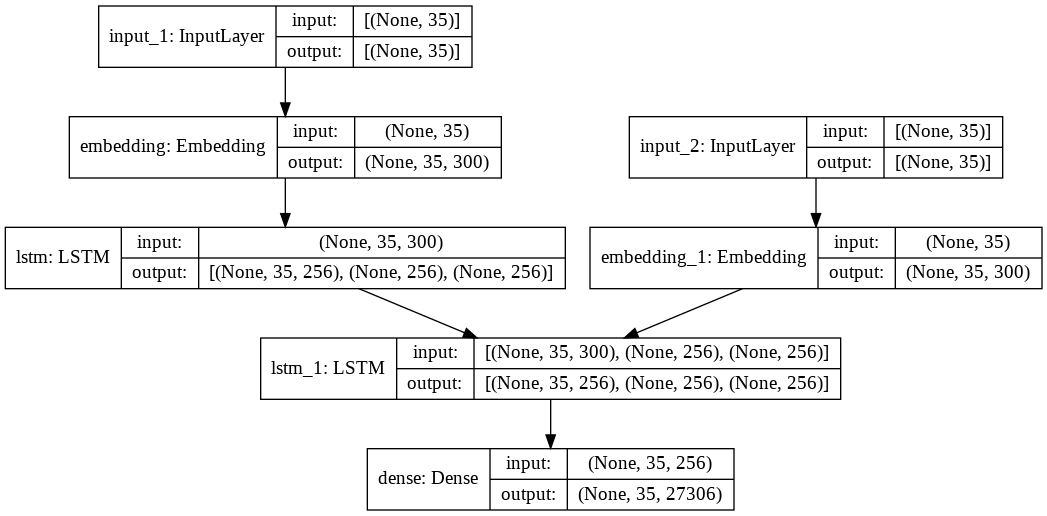

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# LOADING THE WEIGHTS FOR BEST MODEL
model.load_weights("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_trainable_embedding/besh.h5")

In [ ]:
## THIS FUNCTION IS USED IN THE INFERENCE TIME TO PREDICT THE RESULTS GIVEN THE INPUT TEXT

def predict(inp , model):
    ##  TAKES INPUT AS TEXT AND THE MODEL

    # CONVERT TEXT INPUT TO SEQUENCES 
    seq = tk_inp.texts_to_sequences([inp])
    # PADDING THE SEQUENCE
    seq = pad_sequences(seq,maxlen = 35,padding="post")
    ## INITIAL STATES FOR ENCODER
    state = [tf.zeros(shape=(1,256)),tf.zeros(shape= (1,256))]

    # SEQUENCE TO EMBEDDING
    enc_emb  = model.layers[2](seq)
    # PASSING EMBBEDDED SEQUENCES TO LSTM LAYER
    enc_output,state_h,state_c= model.layers[4](enc_emb,state)

    # PLACE HOLDER FOR PREDECTED WORDS
    pred = []
    # PLACE HOLDER FOR STATES 
    input_state = [state_h,state_c]
    # CURRENT VECTOR TO BE PASSED TO DECODER 
    current_vec = tf.ones((1,1))
    
    for i in range(35): # FOR i UP TO 35 (MAX LENGTH)
        ## CONVERT THE CURRENT VECTOR SEQUENCE WORD TO EMBEDDINGS
        dec_emb  = model.layers[3](current_vec)
        ## PASSING EMBEDDED VECTOR TO DECODER LSTM LAYER
        dec_output,dec_state_h,dec_state_c = model.layers[5](dec_emb , input_state)
        # PASSING DECODER OUTPUT TO DENSE LAYER
        dense = model.layers[6](dec_output)

        # SELECTING INDEX OF MAXIMUM DENSE OUTPUT AS CURRENT VECTOR
        current_vec = np.argmax(dense ,axis = -1)
        # UPDATING THE INPUT STATES
        input_state = [dec_state_h,dec_state_c]

        # APPENDING THE ACTUAL TEXT TO "pred" VARIABLE
        pred.append(tk_out.index_word[current_vec[0][0]])
        ## IF THE CURRENT VECTOR IS "<end>" BREAK THE LOOP
        if tk_out.index_word[current_vec[0][0]]=="<end>":
            break
    ## RETURN THE JOINED STRING IN LIST "pred"
    return " ".join(pred)

## PREDICTIONS ON TEST DATASET

In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[19],model))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[19])

INPUT SENTENCE ===>  one day i was in time for the final train
PREDICTED SENTENCE ===>  one day i was in the end of the next time <end>
ACTUAL SENTENCE ===>  one day i was just on time for the final train <end>


In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[50])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[50],model))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[50])

INPUT SENTENCE ===>  i found that some of my firends had been here
PREDICTED SENTENCE ===>  i found that some of my friends have been here <end>
ACTUAL SENTENCE ===>  i found that some of my friends had been here <end>


## Inference Time

In [ ]:
%%time
predict(df_test.enc_input.values[50],model)

CPU times: user 95.4 ms, sys: 11.7 ms, total: 107 ms
Wall time: 92.3 ms


'i found that some of my friends have been here <end>'

## BELU SCORE 

In [ ]:
import nltk.translate.bleu_score as bleu

In [ ]:
# VALIDATION BELU SCORE
BLEU_val_emb = []
test_data = df_val.loc[np.random.choice(df_val.index,size = 2000)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = predict(str(i.enc_input),model).split()
        act = [str(i.dec_output).split()]
        b =bleu.sentence_bleu(act,pred)
        BLEU_val_emb.append(b)
    except:
        continue

2000it [02:21, 14.13it/s]


In [ ]:
print("Triain BELU Score = ",np.mean(BLEU_val_emb))

Triain BELU Score =  0.4603361614149817


##  Model2 - Pre Trained Word Vector

In [ ]:
!wget --header="Host: doc-14-58-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_oli2bj78otd6bj690sskhutcvt4jcljv_nonce=a17t06p88k2ng" --header="Connection: keep-alive" "https://doc-14-58-docs.googleusercontent.com/docs/securesc/l8ia6k4p0fn1kebbsov8ekehei507757/onk0h25n3rm35gh67s449ql1utt8rkp0/1628269950000/06848720943842814915/12599792132870778014/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&authuser=0&nonce=a17t06p88k2ng&user=12599792132870778014&hash=uvrme0lsn4ltpk6ivnbe741c9984e4ih" -c -O 'GoogleNews-vectors-negative300.bin.gz'

--2021-08-06 17:12:54--  https://doc-14-58-docs.googleusercontent.com/docs/securesc/l8ia6k4p0fn1kebbsov8ekehei507757/onk0h25n3rm35gh67s449ql1utt8rkp0/1628269950000/06848720943842814915/12599792132870778014/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&authuser=0&nonce=a17t06p88k2ng&user=12599792132870778014&hash=uvrme0lsn4ltpk6ivnbe741c9984e4ih
Resolving doc-14-58-docs.googleusercontent.com (doc-14-58-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-14-58-docs.googleusercontent.com (doc-14-58-docs.googleusercontent.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors-     [             <=>    ]   1.53G   164MB/s    in 9.8s    

2021-08-06 17:13:06 (161 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227]



In [ ]:
## LOADING THE WORD2VEC MODEL 

from gensim import models
w = models.KeyedVectors.load_word2vec_format(r"GoogleNews-vectors-negative300.bin.gz", binary=True)

In [ ]:
## FORMING EMBEDDING MATRIX FOR INPUT SENTENCE
embedding_matrix_input = np.zeros((len(tk_inp.word_index)+1,300))

for word,index in tqdm(tk_inp.word_index.items()) :
    try:
        vec = w[word]
        embedding_matrix_input[index] = vec
    except:
      
        continue

100%|██████████| 33377/33377 [00:00<00:00, 262674.24it/s]


In [ ]:
# FORMING EMBEDING MATRIX FOR OUTPUT SENTENCE
embedding_matrix_output = np.zeros((len(tk_out.word_index)+1,300))

for word,index in tqdm(tk_out.word_index.items()) :
    try:
        vec = w[word]
        embedding_matrix_output[index] = vec
    except:
   
        continue

100%|██████████| 27305/27305 [00:00<00:00, 263444.09it/s]


## MODEL ARCHITECTURE

In [ ]:
def encoder2(input_shape,vocab, emb_output, lstm_units, enc_input,embedding_matrix):
  
  enc_emb = layers.Embedding(vocab, emb_output,weights= [embedding_matrix] ,mask_zero = True,input_length=input_shape,trainable=False)(enc_input)
  enc_lstm , enc_state_h,enc_state_c = layers.LSTM(units= lstm_units,return_sequences=True,return_state=True)(enc_emb)
  return enc_lstm , enc_state_h,enc_state_c

def decoder2(input_shape,vocab, emb_output, lstm_units,enc_states, dec_input,embedding_matrix):
  
  dec_emb = layers.Embedding(vocab, emb_output ,weights= [embedding_matrix], mask_zero = True,input_length=input_shape,trainable=False)(dec_input)
  dec_lstm, dec_state_h,dec_state_c = layers.LSTM(units=lstm_units,return_sequences=True,return_state=True)(dec_emb,initial_state= enc_states)
  return dec_lstm, dec_state_h,dec_state_c

In [ ]:
enc_input2 = layers.Input(shape=(35))
enc_lstm , enc_state_h,enc_state_c = encoder2(35,len(tk_inp.word_index)+1 , 300 ,256, enc_input2 ,embedding_matrix_input)

dec_input2 = layers.Input(shape = (35))
dec_lstm , dec_state_h,dec_state_c = decoder2(35,len(tk_out.word_index)+1 , 300 , 256 , [enc_state_h,enc_state_c],dec_input2,embedding_matrix_output)

dense2 = layers.Dense(len(tk_out.word_index)+1,activation="softmax")(dec_lstm)

model2  = Model(inputs=[enc_input2,dec_input2],outputs=dense2)

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 300)      10013400    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 300)      8191800     input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
callback2 =[ tf.keras.callbacks.ModelCheckpoint( "/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_w2v/besh.h5",save_best_only=True,mode="min" ,save_weights_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,min_delta=0.0001)
]

train_steps = train_dataloader.__len__()
val_steps  = val_dataloader.__len__()

model2.compile(optimizer="adam",loss='sparse_categorical_crossentropy')

In [ ]:
history = model2.fit(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data = val_dataloader,validation_steps =val_steps,callbacks=callback2)

Epoch 1/50
160/160 [==============================] - 46s 238ms/step - loss: 2.4660 - val_loss: 2.2534
Epoch 2/50
160/160 [==============================] - 36s 222ms/step - loss: 2.2669 - val_loss: 2.1509
Epoch 3/50
160/160 [==============================] - 36s 222ms/step - loss: 2.1248 - val_loss: 2.0014
Epoch 4/50
160/160 [==============================] - 36s 222ms/step - loss: 1.9908 - val_loss: 1.8882
Epoch 5/50
160/160 [==============================] - 36s 222ms/step - loss: 1.8795 - val_loss: 1.7904
Epoch 6/50
160/160 [==============================] - 36s 222ms/step - loss: 1.7864 - val_loss: 1.7124
Epoch 7/50
160/160 [==============================] - 35s 221ms/step - loss: 1.7016 - val_loss: 1.6325
Epoch 8/50
160/160 [==============================] - 36s 222ms/step - loss: 1.6196 - val_loss: 1.5598
Epoch 9/50
160/160 [==============================] - 35s 221ms/step - loss: 1.5447 - val_loss: 1.4964
Epoch 10/50
160/160 [==============================] - 35s 221ms/step - l

In [ ]:
model2.load_weights("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_w2v/besh.h5")

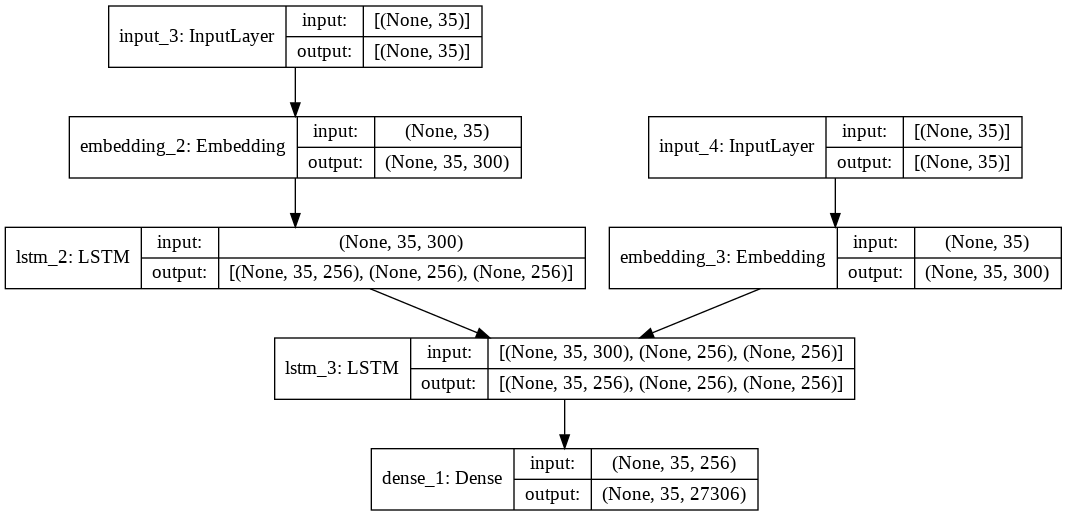

In [ ]:
tf.keras.utils.plot_model( model2 ,show_shapes=True)

## PREDICTIONS FOR TEST DATASET

In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[19],model2))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[19])

INPUT SENTENCE ===>  one day i was in time for the final train
PREDICTED SENTENCE ===>  one day i was in the first time on the train <end>
ACTUAL SENTENCE ===>  one day i was just on time for the final train <end>


In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[50])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[50],model2))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[50])

INPUT SENTENCE ===>  i found that some of my firends had been here
PREDICTED SENTENCE ===>  i found that some of my friends had been here <end>
ACTUAL SENTENCE ===>  i found that some of my friends had been here <end>


## Inference time

In [ ]:
%%time
predict(df_test.enc_input.values[50],model2)

CPU times: user 97.6 ms, sys: 13.4 ms, total: 111 ms
Wall time: 94.5 ms


'i found that some of my friends had been here <end>'

In [ ]:
# VALIDATION BELU SCORE
BLEU_w2v = []
test_data = df_val.loc[np.random.choice(df_val.index,size = 2000)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    try:
        pred = predict(str(i.enc_input),model2).split()
        act = [str(i.dec_output).split()]
        b =bleu.sentence_bleu(act,pred)
        BLEU_w2v.append(b)
    except:
        continue

2000it [02:23, 13.97it/s]


In [ ]:
print("Triain BELU Score = ",np.mean(BLEU_w2v))

Triain BELU Score =  0.44531395413789443


## Model 3 -EMBEDDINGS WITH  FAST TEXT

In [ ]:
!wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://fasttext.cc/" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip" -c -O 'crawl-300d-2M-subword.zip'

--2021-08-06 17:18:57--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  32.1MB/s    in 3m 7s   

2021-08-06 17:22:04 (29.8 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]



In [ ]:
import io
import zipfile
from gensim.models import KeyedVectors
from gensim.models import FastText as fText

In [ ]:
z = zipfile.ZipFile("crawl-300d-2M-subword.zip" , 'r')
z.extractall("ft/")

In [ ]:
ft_model = fText.load_fasttext_format("/content/ft/crawl-300d-2M-subword",encoding='latin1')

In [ ]:
embedding_matrix_ft_input = np.zeros((len(tk_inp.word_index)+1,300))
for word,index in tqdm(tk_inp.word_index.items()) :
    try:
        vec = en_model[word]
        embedding_matrix_ft_input[index] = vec
    except:
        continue

100%|██████████| 33377/33377 [00:00<00:00, 1019178.10it/s]


In [ ]:
embedding_matrix_ft_out = np.zeros((len(tk_out.word_index)+1,300))
for word,index in tqdm(tk_out.word_index.items()) :
    try:
        vec = en_model[word]
        embedding_matrix_ft_out[index] = vec
    except:
        continue

100%|██████████| 27305/27305 [00:00<00:00, 1001797.33it/s]


## MODEL 3 ARCHTECTURE

In [ ]:
def encoder3(input_shape,vocab, emb_output, lstm_units, enc_input,embedding_matrix):
  
  enc_emb = layers.Embedding(vocab, emb_output,weights= [embedding_matrix] ,mask_zero = True,input_length=input_shape,trainable=False)(enc_input)
  enc_lstm , enc_state_h,enc_state_c = layers.LSTM(units= lstm_units,return_sequences=True,return_state=True)(enc_emb)
  return enc_lstm , enc_state_h,enc_state_c

def decoder3(input_shape,vocab, emb_output, lstm_units,enc_states, dec_input,embedding_matrix):
  
  dec_emb = layers.Embedding(vocab, emb_output ,weights= [embedding_matrix], mask_zero = True,input_length=input_shape,trainable=False)(dec_input)
  dec_lstm, dec_state_h,dec_state_c = layers.LSTM(units=lstm_units,return_sequences=True,return_state=True)(dec_emb,initial_state= enc_states)
  return dec_lstm, dec_state_h,dec_state_c

In [ ]:
enc_input3 = layers.Input(shape=(35))
enc_lstm3 , enc_state_h3,enc_state_c3 = encoder3(35,len(tk_inp.word_index)+1 , 300 ,256, enc_input3 ,embedding_matrix_ft_input)

dec_input3 = layers.Input(shape = (35))
dec_lstm3 , dec_state_h3,dec_state_c3 = decoder3(35,len(tk_out.word_index)+1 , 300 , 256 , [enc_state_h3,enc_state_c3],dec_input3,embedding_matrix_ft_out)

dense3 = layers.Dense(len(tk_out.word_index)+1,activation="softmax")(dec_lstm3)

model3  = Model(inputs=[enc_input3,dec_input3],outputs=dense3)

In [ ]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 300)      10013400    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 35, 300)      8191800     input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
callback3 =[ tf.keras.callbacks.ModelCheckpoint( "/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_ft/besh.h5",save_best_only=True,mode="min" ,save_weights_only=True),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,min_delta=0.0001)
]

train_steps = train_dataloader.__len__()
val_steps  = val_dataloader.__len__()

model3.compile(optimizer="adam",loss='sparse_categorical_crossentropy')

In [ ]:
history = model3.fit(train_dataloader,steps_per_epoch=train_steps,epochs=50,validation_data = val_dataloader,validation_steps =val_steps,callbacks=callback3)

Epoch 1/50
160/160 [==============================] - 48s 240ms/step - loss: 0.6246 - val_loss: 0.9766
Epoch 2/50
160/160 [==============================] - 36s 223ms/step - loss: 0.6101 - val_loss: 0.9777
Epoch 3/50
160/160 [==============================] - 36s 222ms/step - loss: 0.6009 - val_loss: 0.9785
Epoch 4/50
160/160 [==============================] - 36s 222ms/step - loss: 0.5916 - val_loss: 0.9797
Epoch 5/50
160/160 [==============================] - 36s 222ms/step - loss: 0.5831 - val_loss: 0.9812
Epoch 6/50
160/160 [==============================] - 36s 223ms/step - loss: 0.5748 - val_loss: 0.9841
Epoch 00006: early stopping


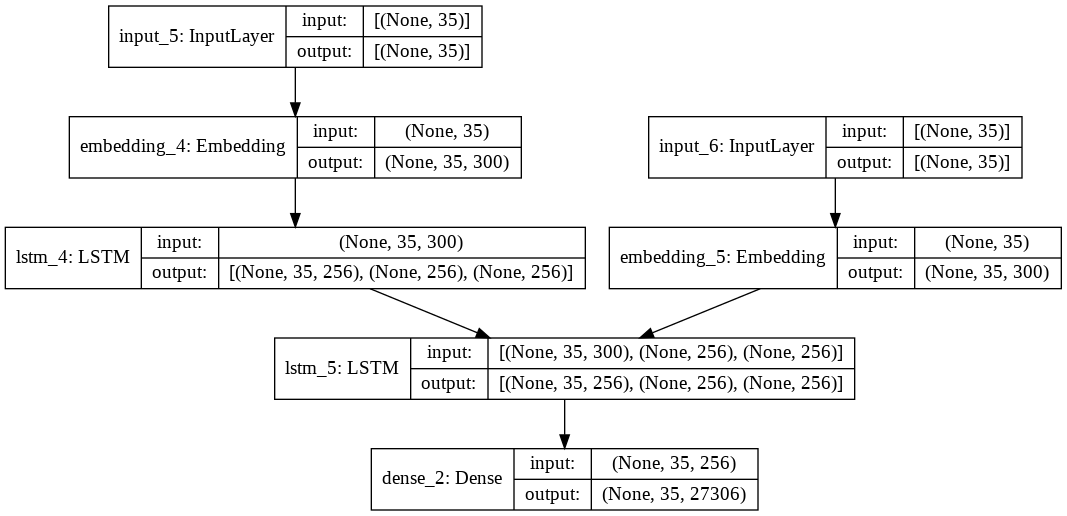

In [ ]:
tf.keras.utils.plot_model(model3,show_shapes=True)

In [ ]:
model3.load_weights("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_ft/besh.h5")

## PREDICTIONS FOR TEST DATASET

In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[19])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[19],model3))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[19])

INPUT SENTENCE ===>  one day i was in time for the final train
PREDICTED SENTENCE ===>  one day i was in the time to pass the train <end>
ACTUAL SENTENCE ===>  one day i was just on time for the final train <end>


In [ ]:
print("INPUT SENTENCE ===> ",df_test.enc_input.values[50])
print("PREDICTED SENTENCE ===> ",predict(df_test.enc_input.values[50],model3))
print("ACTUAL SENTENCE ===> ",df_test.dec_output.values[50])

INPUT SENTENCE ===>  i found that some of my firends had been here
PREDICTED SENTENCE ===>  i found some of my friends that there were here <end>
ACTUAL SENTENCE ===>  i found that some of my friends had been here <end>


## Inference Time

In [ ]:
%%time
predict(df_test.enc_input.values[50],model3)

CPU times: user 98.1 ms, sys: 10.9 ms, total: 109 ms
Wall time: 93.7 ms


'i found some of my friends that there were here <end>'

In [ ]:
# VALIDATION BELU SCORE
BLEU_val_ft = []
test_data = df_val.loc[np.random.choice(df_val.index,size = 2000)]
for ind,i in tqdm(test_data.iterrows(),position=0):
    pred = predict(str(i.enc_input),model3).split()
    act = [str(i.dec_output).split()]
    b =bleu.sentence_bleu(act,pred)
    BLEU_val_ft.append(b)

2000it [02:25, 13.75it/s]


In [ ]:
print("Triain BELU Score = ",np.mean(BLEU_val_ft))

Triain BELU Score =  0.45689500693063134


## Model Comparison

In [ ]:
s1 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/char_trainable_embedding/besh.h5")
s2 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_trainable_embedding/besh.h5")
s3 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_w2v/besh.h5")
s4 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/word_ft/besh.h5")
s5 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/bidirectional_train_emb/besh.h5")
s6 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/multi_layered_word/besh.h5")
s7 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/attention_dot/besh.h5")
s8 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/attention_gernal/best.h5")
s9 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/attention_concat/best.h5")
s10 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monitonic_attention_dot/best.h5")
s11 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monotonic_attention_general/best.h5")
s12 = os.path.getsize("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monotonic_attention_concat/best.h5")


In [ ]:
df_comp = pd.DataFrame()
df_comp["Model"] = ["Encoder Decoder(Char Level)","Encoder Decoder","Encoder Decoder","Encoder Decoder","Bidirectional Encoder Decoder","Multilayered Encoder Decoder","Attention Dot Model","Attention Gernal Model","Attention Concat Model","Monotonic Attention Dot Model","Monotonic Attention Gernal Model","Monotonic Attention Concat Model"]
df_comp["Embedding"] = ["One Hot Encoding","Trainable Embedding" , "Pretrained Word2Vec " ,"Fast Text","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding","Trainable Embedding"]
df_comp["BLEU Score(Greedy Search)"] = [0.3139,0.4603,0.4453,0.4569,0.4509,0.4527, 0.5055,0.5545,0.5388,0.5469,0.5514,0.5348]
df_comp["BLEU Score(Beam Search)"] = ["-","-","-","-",0.4561,0.4557,0.5411,0.5324,0.5671,"-","-","-"]
df_comp["Model Size(bytes)"] = [ s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12]
df_comp["Model Parameters"] = ["616,488	","26,363,578" , "8,158,378", "8,158,378","35,018,938" ," 28,464,826","33,353,914","33,419,706","33,485,755","33,353,914","33,419,706","33,485,755"]
df_comp["Inference Time(ms)"] = [143,92.3 , 94.5 , 93.7,250,311,157,164,189,164,179,176]
df_comp

,Model,Embedding,BLEU Score(Greedy Search),BLEU Score(Beam Search),Model Size(bytes),Model Parameters,Inference Time(ms)
0,Encoder Decoder(Char Level),One Hot Encoding,0.3139,-,2487608,"616,488\t",143.0
1,Encoder Decoder,Trainable Embedding,0.4603,-,105479208,"26,363,578",92.3
2,Encoder Decoder,Pretrained Word2Vec,0.4453,-,105479208,"8,158,378",94.5
3,Encoder Decoder,Fast Text,0.4569,-,105479208,"8,158,378",93.7
4,Bidirectional Encoder Decoder,Trainable Embedding,0.4509,0.4561,140102720,"35,018,938",250.0
5,Multilayered Encoder Decoder,Trainable Embedding,0.4527,0.4557,113894256,"28,464,826",311.0
6,Attention Dot Model,Trainable Embedding,0.5055,0.5411,133440296,"33,353,914",157.0
7,Attention Gernal Model,Trainable Embedding,0.5545,0.5324,133707144,"33,419,706",164.0
8,Attention Concat Model,Trainable Embedding,0.5388,0.5671,133974584,"33,485,755",189.0
9,Monotonic Attention Dot Model,Trainable Embedding,0.5469,-,133440296,"33,353,914",164.0
